In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

import json
from anytree.importer import JsonImporter
from anytree import PreOrderIter

In [2]:
from scipy import stats
from scipy.stats import sem
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import ttest_rel,ttest_ind

In [3]:
%load_ext rpy2.ipython

from rpy2.robjects.packages import importr
# import R's "base" package
lme4 = importr('lme4')
optimx = importr('optimx')
pbkrtest = importr('pbkrtest')
lmerTest = importr('lmerTest')
ggplot = importr('ggplot2')
dplyr = importr('dplyr')
sjplot = importr('sjPlot')
car = importr('car')

In [4]:
home_dir = '/Users/dbao/google_drive_db'+'/road_construction/data/2022_online/'
map_dir = 'active_map/'
data_dir  = 'data/preprocessed'
out_dir = home_dir + 'figures/figures_all/'
R_out_dir = home_dir + 'R_analysis_data/'

In [5]:
data_puzzle_level = pd.read_csv(R_out_dir +  'data.csv')
puzzleID_order_data = data_puzzle_level.sort_values(["subjects","puzzleID","condition"])
data_choice_level = pd.read_csv(R_out_dir +  'choice_level/choicelevel_data.csv')

single_condition_data = puzzleID_order_data[puzzleID_order_data['condition']==1].copy()
single_condition_data = single_condition_data.reset_index()

with open(home_dir +'tree_data/undo_tree', 'r') as file:
    undo_tree = json.load(file)

In [ ]:
# helper functions
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

# add p-value to figure
def text(p):
    if p == 0:
        axs.text((x1+x2)*.5, y+h,  r"$p = {:.1f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    elif p < 0.001:
        axs.text((x1+x2)*.5, y+h, r"$p = {0:s}$".format(as_si(p,1)), ha='center', va='bottom', color=col, fontsize = 8)
    elif p > 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.2f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

    elif 0.01 < p < 0.1:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.3f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)
    else:
        axs.text((x1+x2)*.5, y+h, r"$p = {:.4f}$".format(p), ha='center', va='bottom', color=col, fontsize = 8)

### histogram of the position of branching node

In [ ]:
pos_branching = data_choice_level[data_choice_level['branchingFirst']==True]['currNumCities']

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(pos_branching,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('the postion of branching node') 
plt.show()

## histogram of number of cities within reach

In [ ]:
n_reach = data_choice_level[data_choice_level['condition']==0]['within_reach'] # only basic condition

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(n_reach,
        color = (.7,.7,.7), 
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('number of cities within reach') 
plt.show()

## number of visits to a state (not undo target)

In [ ]:
importer = JsonImporter()
visit = []
for ti in range(len(undo_tree)): # loop through trials
    root = importer.import_(undo_tree[ti])
    
    for node in PreOrderIter(root): # loop through the tree
        n_child = len(node.children)
        visit.append(node.visit)

visit.count(2)

## number of visits to undo target

In [ ]:
each_trial = data_choice_level[data_choice_level['condition']==1].groupby(["subjects","puzzleID"])
n_undotarget_visit = each_trial["branching"].count()
n_undotarget_visit

%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.hist(n_undotarget_visit,
        color = (.7,.7,.7), 
        bins = [2,3,4,5,6,7,8,9],
        edgecolor = 'k',)
axs.set_ylabel('counts') 
axs.set_xlabel('number of undo target visit') 
axs.set_xticks([2,3,4,5,6,7,8])
axs.set_xticklabels(["1","2","3","4","5","6","7+"])
plt.show()

## budget before submit/undo at the end of trial

In [ ]:
# only undo condition
index_first_undo =  data_choice_level.index[data_choice_level['firstUndo'] == 1]
df_beforeUndo = data_choice_level.loc[index_first_undo-1,:]
index_end_undo = df_beforeUndo.index[df_beforeUndo['checkEnd'] == 1]
leftover_undo = df_beforeUndo.loc[index_end_undo,'leftover']

index_notundo = data_choice_level.index[(data_choice_level['undo'] == 0)&(data_choice_level['RT'] != -1)]
df_notbeforeUndo = data_choice_level.loc[index_notundo-1,:]
index_end_notundo = df_notbeforeUndo.index[(df_notbeforeUndo['checkEnd'] == 1)&(df_notbeforeUndo['condition'] == 1)]
leftover_notundo = df_notbeforeUndo.loc[index_end_notundo,'leftover']

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)

bx = axs.boxplot([leftover_undo,leftover_notundo],
   positions =[1,2],widths = 0.3,showfliers=False,whis = 1.5,
   medianprops = dict(color = 'k'))  #

# run 2-independent-sample t test
stat1, p1 = ttest_ind(leftover_undo,leftover_notundo,equal_var=False)
x1, x2 = 1,2  
if bx['caps'][1]._y[0] > bx['caps'][3]._y[0]:
    y, h, col = bx['caps'][1]._y[0] + 2, 0.5, 'k'
else:
    y, h, col = bx['caps'][3]._y[0] + 2, 0.5, 'k'

axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

#--------------------------------------
axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['budget before undo','budget before submit'])#,fontsize=18

axs.set_facecolor('white')
axs.spines['bottom'].set_color('k')
axs.spines['left'].set_color('k')
axs.tick_params(axis='y', colors='k', direction='in',left = True) #, labelsize = 16
axs.tick_params(axis='x', colors='k')
# axs.set_title('S'+str(i+1), fontsize = 16)
axs.set_ylabel('budget') #,fontsize=18

# fig.set_figwidth(26)
# fig.set_figheight(12)

plt.show()
fig.savefig(out_dir + 'budget_before_submit_undo.png', dpi=600, bbox_inches='tight')

## counts of errors before undo (by accumulated severity)

In [ ]:
index_first_undo =  data_choice_level.index[data_choice_level['firstUndo'] == 1]
df_beforeUndo = data_choice_level.loc[index_first_undo-1,:]

MAS_trial = df_beforeUndo['allMAS']
accu_severity_error = MAS_trial - df_beforeUndo['currMas']
groupby_error = accu_severity_error.value_counts()
print(groupby_error/sum(groupby_error))

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar(groupby_error.index,groupby_error/sum(groupby_error))
axs.set_ylabel('proportion of first undo')
axs.set_xlabel('accumulated error before first undo action')
plt.show()
fig.savefig(out_dir + 'undo_accumulated_error.pdf', dpi=600, bbox_inches='tight')

In [ ]:
index_first_undo =  data_choice_level.index[data_choice_level['firstUndo'] == 1]
df_beforeUndo = data_choice_level.loc[index_first_undo-1,:]

instant_severity_error = df_beforeUndo['severityOfErrors']
groupby_error_instant = instant_severity_error.value_counts()
print(groupby_error_instant)

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar(groupby_error.index,groupby_error_instant/sum(groupby_error_instant))
axs.set_ylabel('proportion of first undo')
axs.set_xlabel('instant error before first undo action')
plt.show()
fig.savefig(out_dir + 'undo_instant_error.pdf', dpi=600, bbox_inches='tight')

In [ ]:
# groupby_error_single = single_severity_error.value_counts()
# groupby_error_series = series_severity_error.value_counts()

# groupby_error_series.at[4] = 0
# groupby_error_series.at[6] = 0

In [ ]:
index_single_undo =  data_choice_level.index[(data_choice_level['firstUndo'] == 1)&(data_choice_level['lastUndo'] == 1)]
df_beforeSingleUndo = data_choice_level.loc[index_single_undo-1,:]

single_severity_error = df_beforeSingleUndo['severityOfErrors']
df_beforeSingleUndo['accumulatedError'] = df_beforeSingleUndo['allMAS'] - df_beforeSingleUndo['currMas']
groupby_error_single = df_beforeSingleUndo.groupby(['severityOfErrors','accumulatedError'])['subjects'].count()
groupby_error_single = groupby_error_single.reset_index()

groupby_error_single.loc[groupby_error_single['accumulatedError']>groupby_error_single['severityOfErrors'],'accumulatedError']= 'noninstant'
groupby_error_single = groupby_error_single.groupby(['severityOfErrors','accumulatedError']).sum()
groupby_error_single = groupby_error_single.reset_index()

groupby_error_single['undoType'] = 'single'



index_series_undo =  data_choice_level.index[(data_choice_level['firstUndo'] == 1)&(data_choice_level['lastUndo'] != 1)]
df_beforeSeriesUndo = data_choice_level.loc[index_series_undo-1,:]

series_severity_error = df_beforeSeriesUndo['severityOfErrors']
df_beforeSeriesUndo['accumulatedError'] = df_beforeSeriesUndo['allMAS'] - df_beforeSeriesUndo['currMas']
groupby_error_series = df_beforeSeriesUndo.groupby(['severityOfErrors','accumulatedError'])['subjects'].count()
groupby_error_series = groupby_error_series.reset_index()

groupby_error_series.loc[groupby_error_series['accumulatedError']>groupby_error_series['severityOfErrors'],'accumulatedError']= 'noninstant'
groupby_error_series = groupby_error_series.groupby(['severityOfErrors','accumulatedError']).sum()
groupby_error_series = groupby_error_series.reset_index()

groupby_error_series['undoType'] = 'serial'

groupby_error = pd.concat([groupby_error_single,groupby_error_series])

# add empty entries
d = {'severityOfErrors': [4,4,4,6,6,6], 'accumulatedError': [4,'noninstant','noninstant', 6,'noninstant','noninstant'],'subjects': [0,0,0,0,0,0],'undoType': ['serial','serial','single', 'serial','serial','single',]}
df = pd.DataFrame(data=d)
groupby_error = pd.concat([groupby_error,df]).reset_index()
print(groupby_error)

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
single_index1 = (groupby_error['accumulatedError']!='noninstant')&(groupby_error['undoType']=='single')
single_index2 = (groupby_error['accumulatedError']=='noninstant')&(groupby_error['undoType']=='single')
single_proportion = groupby_error.loc[single_index1 ,'subjects']/sum(groupby_error['subjects'])
single_proportion2 = groupby_error.loc[single_index2 ,'subjects']/sum(groupby_error['subjects'])

serial_index1 = (groupby_error['accumulatedError']!='noninstant')&(groupby_error['undoType']=='serial')
serial_index2 = (groupby_error['accumulatedError']=='noninstant')&(groupby_error['undoType']=='serial')

x = groupby_error.loc[single_index1 ,'severityOfErrors']
width = 0.35  # the width of the bars

axs.bar(x - width/2, single_proportion, width, label='single undo-only instant error',hatch='//',color='#d4a373',edgecolor='black')
axs.bar(x + width/2, single_proportion2, width, label='single undo-with accumulated error',hatch='//',color='#ccd5ae',edgecolor='black')
axs.bar(x - width/2, groupby_error.loc[serial_index1 ,'subjects']/sum(groupby_error['subjects']),width, bottom=single_proportion,
       label='serial undo-only instant error',color='#d4a373',edgecolor='black')
axs.bar(x + width/2, groupby_error.loc[serial_index2 ,'subjects']/sum(groupby_error['subjects']),width, bottom=single_proportion2,
       label='serial undo-with accumulated error',color='#ccd5ae',edgecolor='black')

axs.set_ylabel('proportion of first undo')
axs.set_xlabel('instant error before undo action')
axs.legend()
plt.show()
fig.savefig(out_dir + 'undotype_errortype.pdf', dpi=600, bbox_inches='tight')

## conditional probability of undo

In [ ]:
# FROM EACH SUBJECT
dat_subjects = []
for i in np.unique(np.array(data_choice_level['subjects'])):
    temp_data = []
    index_subjects =  data_choice_level.index[data_choice_level['subjects'] == i]
    
    puzzle_error = data_choice_level['allMAS'] - data_choice_level['currMas']
    
    # no error
    index_error = puzzle_error.index[puzzle_error == 0]
    index_error = np.array(index_error)
    index_error = np.intersect1d(index_error, index_subjects)
    index_error += 1
    if np.any(index_error>(data_choice_level.shape[0]-1)):
        index_error = np.delete(index_error, np.where(index_error>(data_choice_level.shape[0]-1)))
#     temp_data.append(np.mean(data_choice_level['undo'][index_error]))
    temp_data.append(np.mean(data_choice_level['firstUndo'][index_error]))


    # YES error
    index_error = puzzle_error.index[puzzle_error != 0]
    index_error = np.array(index_error)
    index_error = np.intersect1d(index_error, index_subjects)
    index_error += 1
    if np.any(index_error>(data_choice_level.shape[0]-1)):
        index_error = np.delete(index_error, np.where(index_error>(data_choice_level.shape[0]-1)))
#     temp_data.append(np.mean(data_choice_level['undo'][index_error]))
    temp_data.append(np.mean(data_choice_level['firstUndo'][index_error]))
    
    dat_subjects.append(temp_data)

dat_subjects = np.array(dat_subjects)
print(np.mean(dat_subjects,axis=0))
print(np.unique(np.array(data_choice_level['subjects'])))

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar([1,2],np.mean(dat_subjects,axis = 0),color=[.7,.7,.7], edgecolor = 'k', yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))
axs.set_ylabel('P (undo)')
axs.set_xticks([1,2])
axs.set_yticks(np.linspace(0,0.16,5))
axs.set_xticklabels(labels = ['No error', 'Error'])#,fontsize=18
fig.set_figheight(4)
fig.set_figwidth(3)
axs.set_xlabel('puzzle-level')
plt.show()
# fig.savefig(out_dir + 'conditional_undo_masError.pdf', dpi=600, bbox_inches='tight')

from scipy.stats import ttest_ind
stat1, p1 = ttest_ind(dat_subjects[:,0], dat_subjects[:,1])
print(stat1)
print(p1)
axs.set_title('p=' + str(p1))

In [ ]:
# FROM EACH SUBJECT
dat_subjects = []
for i in np.unique(np.array(data_choice_level['subjects'])):
    temp_data = []
    index_subjects =  data_choice_level.index[data_choice_level['subjects'] == i]
    
    # no error
    index_error = data_choice_level['severityOfErrors'].index[data_choice_level['severityOfErrors'] == 0]
    index_error = np.array(index_error)
    index_error = np.intersect1d(index_error, index_subjects)
    index_error += 1
    if np.any(index_error>(data_choice_level.shape[0]-1)):
        index_error = np.delete(index_error, np.where(index_error>(data_choice_level.shape[0]-1)))
#     temp_data.append(np.mean(data_choice_level['undo'][index_error]))
    temp_data.append(np.mean(data_choice_level['firstUndo'][index_error]))


    # YES error
    index_error = data_choice_level['severityOfErrors'].index[data_choice_level['severityOfErrors'] != 0]
    index_error = np.array(index_error)
    index_error = np.intersect1d(index_error, index_subjects)
    index_error += 1
    if np.any(index_error>(data_choice_level.shape[0]-1)):
        index_error = np.delete(index_error, np.where(index_error>(data_choice_level.shape[0]-1)))
#     temp_data.append(np.mean(data_choice_level['undo'][index_error]))
    temp_data.append(np.mean(data_choice_level['firstUndo'][index_error]))
    
    dat_subjects.append(temp_data)

dat_subjects = np.array(dat_subjects)

In [ ]:
%matplotlib notebook

fig, axs = plt.subplots(1, 1)
axs.bar([1,2],np.mean(dat_subjects,axis = 0),color=[.7,.7,.7], edgecolor = 'k', yerr=np.std(dat_subjects,axis = 0)/np.sqrt(dat_subjects.shape[0]))
axs.set_ylabel('P (undo)')
axs.set_xticks([1,2])
axs.set_xticklabels(labels = ['No error', 'Error'])#,fontsize=18
fig.set_figheight(4)
fig.set_figwidth(3)
axs.set_xlabel('move-level')
plt.show()
# fig.savefig(out_dir + 'conditional_pundo_givenError.pdf', dpi=600, bbox_inches='tight')


In [ ]:
ttest_ind
stat1, p1 = ttest_ind(dat_subjects[:,0], dat_subjects[:,1])
print(stat1)
print(p1)
import statsmodels.api as sm
import pylab as py
# sm.qqplot(stats.zscore(dat_subjects[:,0]), line ='45')
sm.qqplot_2samples(dat_subjects[:,0],dat_subjects[:,1],line ='45')
py.show()

## number of undo - subjects

In [ ]:
undo_puzzle = single_condition_data[single_condition_data['numUNDO']>0].groupby(['subjects']).size()
count = [len(single_condition_data.groupby(['subjects']).size())]
for i in range(1,47):
    count.append(sum(undo_puzzle>=i))

In [ ]:
fig, axs = plt.subplots()

plt.bar(list(range(0,47)),count)
axs.set_xlabel("undo in >= number of puzzles")
axs.set_ylabel("number of subjects")
# axs.plot(bins[1][:-1], bins[0], color = '#81b29a', linewidth=3)

## number of undo - puzzles

In [ ]:
order = single_condition_data.groupby(['puzzleID'])['numFullUndo'].mean().to_frame()
sort_order = order.sort_values('numFullUndo')

%matplotlib notebook
fig, axs = plt.subplots(1, 1)

bx = sns.barplot(x='puzzleID', y='numFullUndo', data = single_condition_data, color = '#ccd5ae',order=sort_order.index) 


## benefit of undo - number of full undoing

In [ ]:
basic_score = puzzleID_order_data[puzzleID_order_data['condition']==0]['numCities'].reset_index(drop=True)
basic_score_z = basic_score/puzzleID_order_data[puzzleID_order_data['condition']==0]['mas'].reset_index(drop=True)
single_condition_data['numCities_z'] = single_condition_data['numCities']/single_condition_data['mas']

single_condition_data['undo_benefit'] = single_condition_data['numCities'] - basic_score
single_condition_data['undo_benefit_z'] = single_condition_data['numCities_z'] - basic_score_z

undo_benefit_z_sub = single_condition_data.groupby(['subjects'])['undo_benefit_z'].mean()
undo_count_sub = single_condition_data.groupby(['subjects'])['numFullUndo'].mean()


In [ ]:
# benefit_undo = (np.array(puzzleID_order_data[puzzleID_order_data['condition']==1]['numCities']) 
#         - np.array(puzzleID_order_data[puzzleID_order_data['condition']==0]['numCities']))

# undo_count = np.array(puzzleID_order_data[puzzleID_order_data['condition']==1]['numFullUndo'])

yerr = stats.binned_statistic(undo_count, benefit_undo, statistic=lambda y: np.std(y)/np.sqrt(len(y)), bins=[0,1,2,3,4,100])
bins = stats.binned_statistic(undo_count, benefit_undo, 'mean', bins=[0,1,2,3,4,100])

In [ ]:
fig, axs = plt.subplots()         
axs.plot(bins[1][:-1], bins[0], color = '#81b29a', linewidth=3)
plotline1, caplines1, barlinecols1 = axs.errorbar(bins[1][:-1], bins[0], yerr[0], capsize = 0, ls='None', color='k')

# non-parametric version of anova (because number of observations is different: https://www.reneshbedre.com/blog/anova.html)
# Kruskal-Wallis Test
stat1, p1 = stats.kruskal(benefit_undo[undo_count==1], benefit_undo[undo_count==2], benefit_undo[undo_count==3],benefit_undo[undo_count>=4])
x1, x2 = 1,4  
y, h, col = bins[0][1] + 0.1, 0, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

stat2, p2 = stats.kruskal(benefit_undo[undo_count==0], benefit_undo[undo_count==1], benefit_undo[undo_count==2], benefit_undo[undo_count==3],benefit_undo[undo_count>=4])
x1, x2 = 0,4  
y, h, col = bins[0][1] + 0.05, 0, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p2)

axs.set_xticks([0,1,2,3,4])
axs.set_xticklabels([0,1,2,3,'4+'])
axs.set_xlabel('number of full undoing')
axs.set_ylabel('benefit of undo (n_undo - n_basic)')
fig.savefig(out_dir + 'undobenefit_undonum.png', dpi=600, bbox_inches='tight')

In [ ]:
scatter_data = single_condition_data.groupby(['undo_benefit_z','numFullUndo'])['index'].size().to_frame(name = 'count').reset_index()

In [ ]:
%matplotlib notebook
fig1, ax1 = plt.subplots()
sns.scatterplot(x='numFullUndo', y='undo_benefit_z', size = scatter_data['count'], sizes = (3,100), data=scatter_data) 
ax1.set_xlabel("number of undo")
ax1.set_ylabel("benefit of undo")

In [ ]:
fig11, ax1 = plt.subplots()
ax1.plot(undo_count_sub,undo_benefit_z_sub,'o')
ax1.set_xlabel("average number of undo")
ax1.set_ylabel("benefit of undo")
fig11.savefig(out_dir + 'undobenefit_individual.pdf', dpi=600, bbox_inches='tight')

In [ ]:
#TODO: with a caption stating that each point is a subject, the Spearman rho, and the p-value
stats.spearmanr(undo_count_sub,undo_benefit_z_sub)

In [ ]:
undo_benefit_puzzle = single_condition_data.groupby(['puzzleID'])['undo_benefit'].mean()
undo_count_puzzle = single_condition_data.groupby(['puzzleID'])['numFullUndo'].mean()
fig1, ax1 = plt.subplots()
ax1.plot(undo_count_puzzle,undo_benefit_puzzle,'o')
ax1.set_xlabel("average number of undo")
ax1.set_ylabel("benefit of undo")

## GLMM benefit of undo - number of undo

In [ ]:
basic_score = puzzleID_order_data[puzzleID_order_data['condition']==0]['numCities'].reset_index(drop=True)
basic_score_z = basic_score/puzzleID_order_data[puzzleID_order_data['condition']==0]['mas'].reset_index(drop=True)
single_condition_data['numCities_z'] = single_condition_data['numCities']/single_condition_data['mas']

single_condition_data['undo_benefit'] = single_condition_data['numCities'] - basic_score
single_condition_data['undo_benefit_z'] = single_condition_data['numCities_z'] - basic_score_z

undo_benefit_z_sub = single_condition_data.groupby(['subjects'])['undo_benefit_z'].mean()
undo_count_sub = single_condition_data.groupby(['subjects'])['numFullUndo'].mean()

In [ ]:
%%R -i single_condition_data

single_condition_data$subjects <- factor(single_condition_data$subjects)
single_condition_data$puzzleID <- factor(single_condition_data$puzzleID)
single_condition_data$mas <- factor(single_condition_data$mas)
# single_condition_data$numFullUndo[single_condition_data$numFullUndo >4] <- 4
# single_condition_data$numFullUndo <- factor(single_condition_data$numFullUndo)

str(single_condition_data)

In [ ]:
%%R

model = lmer(undo_benefit_z ~ numFullUndo + (numFullUndo|subjects),
                                  data=single_condition_data , control=lmerControl(optimizer="optimx",
                                                                   optCtrl=list(method="nlminb")))

# get the coefficients for the best fitting model
summary(model)

In [ ]:
%%R
# anova(model)
# plot(model)

ranef(model)
## QQ-plots:
# par(mfrow = c(1, 2))
# qqnorm(ranef(model)$subjects[, 1], main = "Random effects of subjects")
# qqnorm(resid(model), main = "Residuals")

qqPlot(resid(model), distribution = "norm")

## glmm：missed points - number of undo

In [6]:
puzzleID_order_data['missed_points'] = puzzleID_order_data['mas'] - puzzleID_order_data['numCities']
puzzleID_order_data = puzzleID_order_data[puzzleID_order_data['missed_points'] >= 0]

In [7]:
%%R -i puzzleID_order_data

puzzleID_order_data$subjects <- factor(puzzleID_order_data$subjects)
puzzleID_order_data$puzzleID <- factor(puzzleID_order_data$puzzleID)
puzzleID_order_data$condition <- factor(puzzleID_order_data$condition)
puzzleID_order_data$missed_points_sqrt <- sqrt(puzzleID_order_data$missed_points)
str(puzzleID_order_data)

'data.frame':	9291 obs. of  20 variables:
 $ subjects          : Factor w/ 101 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ puzzleID          : Factor w/ 46 levels "0","1","2","3",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ reward            : int  81 81 36 49 100 100 64 81 81 81 ...
 $ numCities         : int  9 9 6 7 10 10 8 9 9 9 ...
 $ mas               : int  9 9 7 7 10 10 10 10 10 10 ...
 $ nos               : int  104 104 6 6 70 70 34 34 4 4 ...
 $ leftover          : num  1.37 12.88 26.52 20.82 28.4 ...
 $ numError          : int  0 1 1 3 0 0 2 1 1 1 ...
 $ sumSeverityErrors : int  0 1 1 3 0 0 2 1 1 1 ...
 $ condition         : Factor w/ 2 levels "0","1": 1 2 1 2 1 2 1 2 1 2 ...
 $ numUNDO           : int  0 6 0 11 0 7 0 0 0 0 ...
 $ numFullUndo       : int  0 1 0 3 0 1 0 0 0 0 ...
 $ numEnd            : int  1 2 1 4 1 2 1 1 1 1 ...
 $ TT                : num  21.3 48.6 22.2 62.3 20 ...
 $ RT1               : num  6.78 6.99 8.73 12.95 4.69 ...
 $ RTlater           : num  2.44 3 4.1

In [8]:
%%R

model0 = lme4::glmer(missed_points ~ condition + numFullUndo + (1|subjects) + (1|puzzleID) + (condition + 0 | subjects),
                                  data = puzzleID_order_data, family = "poisson")

# get the coefficients for the best fitting model
summary(model0)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: missed_points ~ condition + numFullUndo + (1 | subjects) + (1 |  
    puzzleID) + (condition + 0 | subjects)
   Data: puzzleID_order_data

     AIC      BIC   logLik deviance df.resid 
 19010.2  19067.3  -9497.1  18994.2     9283 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.9438 -0.6512 -0.3345  0.4740  8.2079 

Random effects:
 Groups     Name        Variance Std.Dev. Corr
 subjects   condition0  0.0710   0.2665       
            condition1  0.1608   0.4010   0.98
 subjects.1 (Intercept) 0.1653   0.4066       
 puzzleID   (Intercept) 0.1962   0.4429       
Number of obs: 9291, groups:  subjects, 101; puzzleID, 46

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.348814   0.083272  -4.189 2.80e-05 ***
condition1  -0.248191   0.033257  -7.463 8.47e-14 ***
numFullUndo -0.006175   0.020397  -0.303    0.762 

239 190 
254 271 


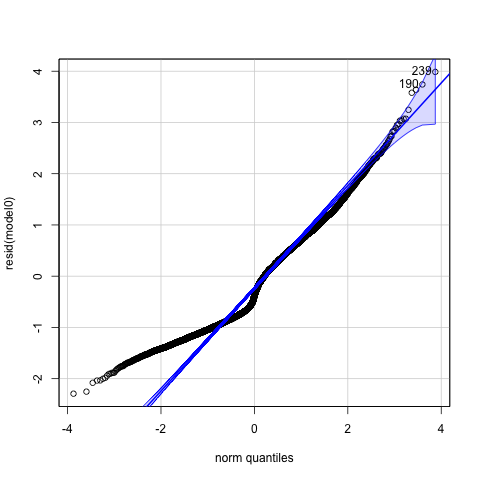

In [9]:
%%R
# anova(model)
# plot(model)

# ranef(model)
## QQ-plots:
# par(mfrow = c(1, 2))
# qqnorm(ranef(model)$subjects[, 1], main = "Random effects of subjects")
# qqnorm(resid(model), main = "Residuals")

qqPlot(resid(model0), distribution = "norm")

In [10]:
%%R

model1 = lme4::glmer(missed_points ~ condition + numFullUndo + (1|subjects) + (1|puzzleID),
                                  data = puzzleID_order_data, family = "poisson")

# get the coefficients for the best fitting model
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: missed_points ~ condition + numFullUndo + (1 | subjects) + (1 |  
    puzzleID)
   Data: puzzleID_order_data

     AIC      BIC   logLik deviance df.resid 
 19019.9  19055.5  -9504.9  19009.9     9286 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0443 -0.6549 -0.3443  0.4758  7.5603 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjects (Intercept) 0.2649   0.5146  
 puzzleID (Intercept) 0.1964   0.4432  
Number of obs: 9291, groups:  subjects, 101; puzzleID, 46

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.36682    0.08486  -4.322 1.54e-05 ***
condition1  -0.18624    0.02467  -7.550 4.34e-14 ***
numFullUndo -0.02930    0.01892  -1.549    0.121    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) cndtn1
condition1  -0.111  

In [11]:
%%R

anova(model0,model1)

Data: puzzleID_order_data
Models:
model1: missed_points ~ condition + numFullUndo + (1 | subjects) + (1 | puzzleID)
model0: missed_points ~ condition + numFullUndo + (1 | subjects) + (1 | puzzleID) + (condition + 0 | subjects)
       npar   AIC   BIC  logLik deviance Chisq Df Pr(>Chisq)   
model1    5 19020 19056 -9504.9    19010                       
model0    8 19010 19067 -9497.1    18994 15.65  3   0.001338 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


## count of error - number of optimal solutions

In [ ]:
error_basic = np.array(puzzleID_order_data[puzzleID_order_data['condition']==0]['numError']) 
# error_undo = np.array(puzzleID_order_data[puzzleID_order_data['condition']==1]['numError']) 

n_optimal = np.array(puzzleID_order_data[puzzleID_order_data['condition']==1]['nos'])

bins1 = stats.binned_statistic(n_optimal, error_basic, 'mean', bins=[1,3,6,9,100])
# bins2 = stats.binned_statistic(n_optimal, error_undo, 'mean', bins=[1,3,6,9,15])

fig, axs = plt.subplots()         
axs.plot(bins1[1][:-1], bins1[0], color = '#81b29a', linewidth=3,label='basic')
# axs.plot(bins2[1][:-1], bins2[0],linewidth=3,label='undo')

# non-parametric version of anova (because number of observations is different: https://www.reneshbedre.com/blog/anova.html)
# Kruskal-Wallis Test
stat1, p1 = stats.kruskal(error_basic[(n_optimal<3) & (n_optimal>=1)], error_basic[(n_optimal<6) & (n_optimal>=3)], error_basic[(n_optimal<9) & (n_optimal>=6)],error_basic[n_optimal>=9])
x1, x2 = 1,9
y, h, col = bins1[0][0] + 0.05, 0, 'k'
axs.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
text(p1)

axs.set_xlabel('number of optimal solutions')
axs.set_ylabel('count of error')
axs.set_xticks([1,3,6,9])
axs.set_xticklabels([1,3,6,'9+'])
# axs.legend()
fig.savefig(out_dir + 'error_optimal.png', dpi=600, bbox_inches='tight')
